# Exploring Recipe Types with Fewer Steps: An Analysis of Simplicity and Efficiency in Cooking

**Name(s)**: An-Chi Lu, Nomin Batjargal

**Website Link**: https://nomin709.github.io/analysis_for_recipes/

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
# pio.renderers.default = 'notebook'
# pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.
import ast
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Step 1: Introduction

In [2]:
# Question: What types of recipes tend to have lower number of steps (the least number of steps)?

In [145]:
recipes_fp = Path('food_data') / 'RAW_recipes.csv'
interactions_fp = Path('food_data') / 'RAW_interactions.csv'
recipes = pd.read_csv(recipes_fp)
interactions = pd.read_csv(interactions_fp)

In [4]:
recipes.head()

,name,id,minutes,contributor_id,...,steps,description,ingredients,n_ingredients
0,1 brownies in the world best ever,333281,40,985201,...,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9
1,1 in canada chocolate chip cookies,453467,45,1848091,...,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",11
2,412 broccoli casserole,306168,40,50969,...,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9
3,millionaire pound cake,286009,120,461724,...,"['freheat the oven to 300 degrees', 'grease a ...",why a millionaire pound cake? because it's su...,"['butter', 'sugar', 'eggs', 'all-purpose flour...",7
4,2000 meatloaf,475785,90,2202916,...,"['pan fry bacon , and set aside on a paper tow...","ready, set, cook! special edition contest entr...","['meatloaf mixture', 'unsmoked bacon', 'goat c...",13


In [5]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
1,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
2,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
3,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
4,2000192946,120345,2015-05-10,2,This recipe was OVERLY too sweet. I would sta...


## Step 2: Data Cleaning and Exploratory Data Analysis

In [6]:
# Special Consideration

In [7]:
# Data Cleaning

In [146]:
# 1. left merge the recipes and interactions datasets on 'id' for recipes and 'recipe_id' for interactions.
merged_df = recipes.merge(interactions, left_on='id', right_on='recipe_id', how='left')

In [147]:
# 2. fill all ratings of 0 with np.nan --> Think about why this is a reasonable step, and include your justification in your website.
merged_df['rating'] = merged_df['rating'].replace(0, np.nan)

In [148]:
# 3./4. add a new column 'rating_avg' that contains the average rating per recipe
avg_rating = merged_df.groupby('id')['rating'].mean()
merged_df = merged_df.join(avg_rating, on='id', how='left', rsuffix='_avg')

In [11]:
# Convert data type and further dataframe modification 

In [12]:
# tags column is an object type which means the list is actually stored as strings so may have to convert it to an actual list,
# merged_df['tags'].apply(ast.literal_eval) converts string to list object
# may have to drop columns and only include columns relevant to the analysis/project for efficiency 
# determine what columns are needed and transform or clean accordingly

In [149]:
# convert tags from string to list
merged_df['tags'] = merged_df['tags'].map(ast.literal_eval)

In [159]:
# Convert 'user_id' column to integers (ignores NaN, keeps it as NaN)
merged_df['user_id'] = merged_df['user_id'].astype('Int64')

# Convert 'recipe_id' column to integers (ignores NaN, keeps it as NaN)
merged_df['recipe_id'] = merged_df['recipe_id'].astype('Int64')

# drop steps
merged_df = merged_df.drop(columns = ['steps'])

In [162]:
merged_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,rating_avg
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"[60-minutes-or-less, time-to-make, course, mai...","[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]",10,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9,386585,333281,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"[60-minutes-or-less, time-to-make, cuisine, pr...","[595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]",12,this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",11,424680,453467,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0
2,412 broccoli casserole,306168,40,50969,2008-05-30,"[60-minutes-or-less, time-to-make, course, mai...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,29782,306168,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0
3,412 broccoli casserole,306168,40,50969,2008-05-30,"[60-minutes-or-less, time-to-make, course, mai...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,1196280,306168,2009-04-13,5.0,I made this for my son's first birthday party ...,5.0
4,412 broccoli casserole,306168,40,50969,2008-05-30,"[60-minutes-or-less, time-to-make, course, mai...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,768828,306168,2013-08-02,5.0,Loved this. Be sure to completely thaw the br...,5.0


In [163]:
print(merged_df.head().to_markdown(index=False))

| name                                 |     id |   minutes |   contributor_id | submitted   | tags                                                                                                                                                                                                                        | nutrition                                    |   n_steps | description                                                                                                                                                                                                                                                                                                                                                                       | ingredients                                                                                                                                                                    |   n_ingredients |   user_id |   recipe_id | date       |   rating | review 

In [164]:
# Convert DataFrame to HTML and save it to a file? 
merged_df.head().to_html('assets/dataframe.html', index=False)

In [17]:
# Univariate Analysis

In [52]:
# Frequency of Recipes by Number of Steps
univariate = px.histogram(merged_df, x = 'n_steps', title='Distribution of Number of Steps')
univariate

In [19]:
merged_df['n_steps'].isnull().sum()

np.int64(0)

In [20]:
merged_df['n_steps'].mean(), merged_df['n_steps'].median(), merged_df['n_steps'].max(), merged_df['n_steps'].min()

(np.float64(10.01783482418984), np.float64(9.0), np.int64(100), np.int64(1))

In [53]:
# Save the plot as an HTML file
univariate.write_html('assets/univariate.html', include_plotlyjs='cdn')


In [58]:
univariate_ingredients = px.histogram(merged_df, x = 'n_ingredients', title='Distribution of Number of Ingredients')
univariate_ingredients

In [38]:
merged_df['n_ingredients'].isnull().sum()

np.int64(0)

In [25]:
merged_df['n_ingredients'].mean(), merged_df['n_ingredients'].median(), merged_df['n_ingredients'].max(), merged_df['n_ingredients'].min()

(np.float64(106.78966339488716),
 np.float64(35.0),
 np.int64(1051200),
 np.int64(0))

In [26]:
# Bivariate Analysis

In [82]:
# find the relationship between number of steps and minutes
# for steps less than 5 and less than 2 hours (120 minutes)
smaller_than_5 = merged_df[(merged_df['n_steps'] <= 5) & (merged_df['minutes'] <= 120)]
smaller_than_5.plot(kind = 'scatter', x = 'n_steps', y = 'minutes', title = 'Relationship Between Minutes and Number of Steps')

In [60]:
# find the relationship between number of steps and number of ingredients
bivariate = merged_df.plot(kind = 'scatter', x = 'n_steps', y = 'n_ingredients', title = 'Relationship Between Number of Steps and Number of Ingredients')
bivariate

In [64]:
merged_df['n_ingredients'].isnull().sum()

np.int64(0)

In [61]:
bivariate.write_html('assets/bivariate.html', include_plotlyjs='cdn')

Text(0.5, 1.0, 'Relationship Between Number of Steps and Rating')

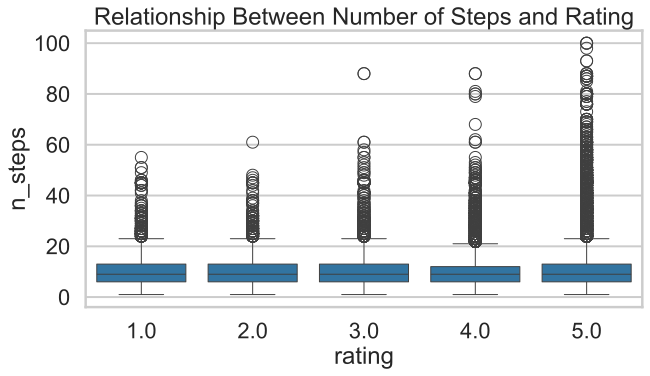

In [57]:
# find the relationship between rating and number of steps
sns.boxplot(data=merged_df, x='rating', y='n_steps'); plt.title('Relationship Between Number of Steps and Rating')

In [30]:
# Interesting Aggregate

In [133]:
# looking for recipes with less than 3 steps and less than 10 minutes
efficient = merged_df[(merged_df['n_steps'] <= 3)]
efficient

,name,id,minutes,contributor_id,...,recipe_id,date,rating,rating_avg
21,go to bbq sauce for ribs,495314,13,488441,...,495314,2013-03-02,5.0,5.0
60,outback steak rub,343448,5,751759,...,343448,2009-07-11,4.0,4.0
61,outback steak rub,343448,5,751759,...,343448,2009-09-21,5.0,4.0
...,...,...,...,...,...,...,...,...,...
234411,zydeco sauce,357451,15,461283,...,357451,2009-02-26,5.0,5.0
234412,zydeco sauce,357451,15,461283,...,357451,2009-03-30,5.0,5.0
234419,zydeco spice mix,493372,5,1500678,...,493372,2013-01-17,5.0,5.0


In [134]:
# flatten tags
explode_tags = efficient['tags'].explode()

# filter tags with '-' inside --> most of them doesn't relate to type of recipes 
filtered_tags = pd.Series(explode_tags[~explode_tags.str.contains('-', regex=False)])

first_30 = filtered_tags.value_counts()[:30]

# Tags to keep
# we will focus on tags that has specific description of types 
tags_to_keep = ['vegetarian', 'fruit', 'salads', 'european', 'american', 'appetizers', 'breakfast', 'brunch', 'lunch', 'desserts']

# Filter the Series by these tags
#top_10_recipes = explode_tags[explode_tags.index.isin(tags_to_keep)]
# we use tags to represent types of recipes, since there are lots of tags that represent characteristics of recipes rather than types of recipes
# we manually find the top 10 most common recipes which are the following --> subjective 

In [137]:
list(first_30.index)

['preparation',
 'easy',
 'course',
 'dietary',
 'occasion',
 'cuisine',
 'beverages',
 'healthy',
 'vegetarian',
 'vegetables',
 'fruit',
 'inexpensive',
 'equipment',
 'salads',
 'cocktails',
 'vegan',
 'american',
 'appetizers',
 'meat',
 'european',
 'seasonal',
 'presentation',
 'weeknight',
 'lunch',
 'desserts',
 'smoothies',
 'brunch',
 'sauces',
 'breakfast',
 'summer']

In [138]:
# Explode the 'tags' list to turn each tag into a separate row
exploded_df = efficient.explode('tags')

# Filter for rows that contain any of the specified tags
filtered_exploded_df = exploded_df[exploded_df['tags'].isin(tags_to_keep)]

# instead of saying types it is more based on attributes 

In [139]:
pivot_table = filtered_exploded_df.pivot_table(index = "tags", columns = "n_steps", values = "minutes", aggfunc = "mean")

In [140]:
print(pivot_table.to_markdown(index=True))

| tags       |        1 |       2 |       3 |
|:-----------|---------:|--------:|--------:|
| american   |  18.8945 | 59.9345 | 40.8085 |
| appetizers |  12.4509 | 41.2602 | 36.2605 |
| breakfast  |  36.7671 | 18.0526 | 30.2157 |
| brunch     | 100.421  | 10.2177 | 31.021  |
| desserts   |  15.2672 | 20.0771 | 38.6757 |
| european   |  46.2705 | 25.7961 | 37.1663 |
| fruit      |  30.574  | 14.4203 | 25.3304 |
| lunch      |  52.9877 | 17.5945 | 34.9934 |
| salads     |  24.5385 | 17.5127 | 23.2074 |
| vegetarian |  10.7028 | 23.1497 | 25.9033 |


## Step 3: Assessment of Missingness

In [141]:
# Special Consideration
# There are only three columns in the merged dataset that contain missing values; make sure you’re using the merged dataset for all of your analysis (and that you followed the steps at the top of this page exactly).

In [166]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if working with a DataFrame)
pd.set_option('display.width', None)  # Adjust width for proper formatting

print(merged_df.isnull().sum())

name                  1
id                    0
minutes               0
contributor_id        0
submitted             0
tags                  0
nutrition             0
n_steps               0
description         114
ingredients           0
n_ingredients         0
user_id               1
recipe_id             1
date                  1
rating            15036
review               58
rating_avg         2777
dtype: int64


In [142]:
missing_values = merged_df.isnull().sum()
missing_values[missing_values > 0]

name              1
user_id           1
recipe_id         1
date              1
rating        15036
rating_avg     2777
dtype: int64

In [ ]:
# columns with missing values: rating, review, description
# dependent on: n_steps, minutes
df_mar = merged_df.copy()
df_mar['rating_missing'] = df_mar['rating'].isna()

In [ ]:
stats1, obs1 = permutation_test(df_mar, 'n_steps', 'rating_missing', abs_diff_in_means)
p_val = (stats1 >= obs1).mean() 
p_val

np.float64(0.0)

In [ ]:
fig = px.histogram(pd.DataFrame(stats1), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=obs1, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(obs1, 2)}</span>',
                   x=2 * obs1, showarrow=False, y=0.07)

In [ ]:
create_kde_plotly(df_mar, 'rating_missing', True, False, 'n_steps', " by Missingness of (MAR Example)")

In [ ]:
stats2, obs2 = permutation_test(df_mar, 'minutes', 'rating_missing', abs_diff_in_means)
p_val = (stats2 >= obs2).mean() 
p_val

np.float64(0.102)

In [ ]:
fig = px.histogram(pd.DataFrame(stats2), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=obs2, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(obs2, 2)}</span>',
                   x=2 * obs2, showarrow=False, y=0.07)

In [ ]:
create_kde_plotly(df_mar, 'rating_missing', True, False, 'minutes', " by Missingness of (MAR Example)")

## Step 4: Hypothesis Testing

In [ ]:
# filter recipes with tags that include 'breakfast' or 'lunch' using the original raw recipes dataset
breakfast_lunch = recipes[recipes['tags'].apply(lambda x: 'breakfast' in x) | recipes['tags'].apply(lambda x: 'lunch' in x)]

# label each recipe as either 'breakfast' or 'lunch' using tags
breakfast_lunch = breakfast_lunch.assign(breakfast_lunch = recipes['tags'].apply(lambda x: 'breakfast' if 'breakfast' in x else 'lunch'))

In [ ]:
# p-val < 0.01, reject the null, 
# meaning the average number of steps for breakfast and lunch have a significant difference
stats, obs = permutation_test(breakfast_lunch, 'n_steps', 'breakfast_lunch', abs_diff_in_means)
p_val = (stats >= obs).mean() 
p_val

np.float64(0.0)

## Step 5: Framing a Prediction Problem

In [ ]:
# TODO

## Step 6: Baseline Model

In [ ]:
# Prediction Problem: regression
# Response variable: n_steps
# Features: minutes, n_ingredients

In [ ]:
# define X and y variables
X = merged_df[['minutes', 'n_ingredients']]
y = merged_df['n_steps']
# split data into training and test set (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit RandomForestRegressor pipeline
pl1 = make_pipeline(RandomForestRegressor(max_depth=5))
pl1.fit(X_train, y_train)

# Evaluate model performance on train and test sets
train_score = pl1.score(X_train, y_train)
test_score = pl1.score(X_test, y_test)

# Make predictions
y_train_pred = pl1.predict(X_train)
y_test_pred = pl1.predict(X_test)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

# Print results with clear labels
print(f"Train R^2 Score: {train_score:.4f}")
print(f"Test R^2 Score: {test_score:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train R^2 Score: 0.2670
Test R^2 Score: 0.2708
Train RMSE: 5.5104
Test RMSE: 5.5222


## Step 7: Final Model

In [ ]:
# Prediction Problem: regression
# Response variable: n_steps
# Features: minutes, n_ingredients, rating (avg rating), tags

In [ ]:
# choose 10 tags: breakfast, lunch, dinner, snacks, desserts, beverages, appetizers, vegetarian, side-dishes
tags_to_encode = ['breakfast', 'lunch', 'dinner', 'snacks', 'desserts', 'beverages', 'appetizers', 'vegetarian', 'side-dishes']

In [ ]:
def create_tag_features(X): 
    df = X.copy()
    for tag in tags_to_encode: 
        df[tag] = df['tags'].apply(lambda x: 1 if tag in x else 0) 

    return df.drop(columns=['tags']) 

In [ ]:
preproc = make_column_transformer(
    (FunctionTransformer(np.log1p), ['minutes']),
    (FunctionTransformer(create_tag_features), ['tags']),
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [ ]:
X2 = merged_df[['minutes', 'n_ingredients', 'tags', 'rating_avg']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [ ]:
hyperparameters = {
    'randomforestregressor__max_depth': [5, 10, 20, 30],
    'randomforestregressor__n_estimators': [50, 100, 150]
}

searcher = GridSearchCV(
    make_pipeline(preproc, RandomForestRegressor(random_state=42)),  # Use the pipeline with Random Forest
    param_grid=hyperparameters,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',  # RMSE (negative because GridSearchCV maximizes)
    n_jobs=-1,  # Use all available cores
)

searcher.fit(X2_train, y2_train)

/Users/nomin1/miniforge3/envs/dsc80/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('functiontransformer-1',
                                                                         FunctionTransformer(func=<ufunc 'log1p'>),
                                                                         ['minutes']),
                                                                        ('functiontransformer-2',
                                                                         FunctionTransformer(func=<function create_tag_features at 0x315922fc0>),
                                                                         ['tags'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 10, 20, 30],
                         'randomforestregressor__min_samples_split': [2, 5, 10],
                         'randomforestregressor__n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [ ]:
best_model = searcher.best_estimator_

# Print the best model
print("Best Model:", best_model)


print("\nBest hyperparameters:")
print(searcher.best_params_)

Best Model: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['minutes']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function create_tag_features at 0x315922fc0>),
                                                  ['tags'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=30, n_estimators=150,
                                       random_state=42))])

Best hyperparameters:
{'randomforestregressor__max_depth': 30, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 150}


In [ ]:
# You can now use the best model for prediction
y_train_pred_best = best_model.predict(X2_train)
y_test_pred_best = best_model.predict(X2_test)

# calculate r squared scores
train_r2_best = best_model.score(X2_train, y2_train)
test_r2_best = best_model.score(X2_test, y2_test)

# Calculate RMSE for the best model on train and test sets
train_rmse_best = root_mean_squared_error(y2_train, y_train_pred_best)
test_rmse_best = root_mean_squared_error(y2_test, y_test_pred_best)

# Print RMSE for the best model
# Print the R^2 scores
print(f"Train R^2 Score (Best Model): {train_r2_best:.4f}")
print(f"Test R^2 Score (Best Model): {test_r2_best:.4f}")
print(f"Train RMSE (Best Model): {train_rmse_best:.4f}")
print(f"Test RMSE (Best Model): {test_rmse_best:.4f}")

Train R^2 Score (Best Model): 0.7375
Test R^2 Score (Best Model): 0.6318
Train RMSE (Best Model): 3.2974
Test RMSE (Best Model): 3.9237


In [ ]:
best_model.fit(X2, y)

y_full_pred = best_model.predict(X2)

# Calculate RMSE for the entire data (combined train + test data)
final_rmse = root_mean_squared_error(y, y_full_pred)
final_r2 = best_model.score(X2, y)

# Print the final performance metrics
print(f"Final R^2 Score (trained on all data): {final_r2:.4f}")
print(f"Final RMSE (trained on all data): {final_rmse:.4f}")

Final R^2 Score (trained on all data): 0.7345
Final RMSE (trained on all data): 3.3194


## Step 8: Fairness Analysis

In [ ]:
# does my model perform worse for individuals in Group X than it does for individuals in Group Y?
# evaluation metric: rmse
# Group X: Recipes with ratings above 3.0
# Group Y: Recipes with ratings below 3.0

In [ ]:
merged_df['n_steps_pred'] = y_full_pred
merged_df['low_rating'] = (merged_df['rating_avg'] < 4).replace({True: 'low', False: 'high'})

In [ ]:
# calculate rmse by group
rmse_by_group = merged_df.groupby('low_rating').apply(
    lambda group: root_mean_squared_error(group['n_steps'], group['n_steps_pred']), include_groups=False
    ).reset_index(name='rmse')

# Observed difference in RMSE
observed_diff = abs(rmse_by_group['rmse'].diff().iloc[-1])

# Number of permutations
n_permutations = 1000
permuted_diffs = []

# Perform the permutations
for _ in range(n_permutations):
    # Shuffle the 'minutes' labels (so group assignment is random)
    merged_df['low_rating'] = np.random.permutation(merged_df['low_rating'].values)
    
    # Calculate RMSE for the permuted groups
    rmse_by_group = merged_df.groupby('low_rating').apply(
        lambda group: root_mean_squared_error(group['n_steps'], group['n_steps_pred']
        ), include_groups=False).reset_index(name='rmse')
    
    # Calculate the difference in RMSE for the permuted groups
    perm_diff = rmse_by_group['rmse'].diff().iloc[-1]
    permuted_diffs.append(abs(perm_diff))

In [ ]:
# p_value around 0.379 which is > 0.05 thus fail to reject null that our model is fair
p_val = (permuted_diffs >= observed_diff).mean() 
p_val

np.float64(0.379)

In [ ]:
fig = px.histogram(pd.DataFrame(permuted_diffs), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=observed_diff, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(observed_diff, 2)}</span>',
                   x=2 * observed_diff, showarrow=False, y=0.07)